# Developing neighbourhood rating system by example of the city of Toronto
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

It is very important to find a good place where to live, where to do business. Computer science definitely can help it. This research investigates how to build recommendations systems, that can be applied to any large city and provide information about most suitable areas to do the activities for it's users. The city of Toronto is an example how to do it. The key feature is capturing all available venues data around the city. Foursquare location data is a good opportunity fastly collect all the data. The problem to be solved is to find districts with the most advanced infrastructure. All needed places must be close with good variety. Then districts can be clustered for areas with life quality and business value above average. After all customer can explore the map with areas highlighted for their requirements. So the target audience both as small business as ordinary citizens. One can explore the map to find best places for renting. Also it is suitable for helping to establish new public plase to do business.

## Data <a name="data"></a>

First of all, public data for Toronto neighbourhoods are loaded. Then not assigned data are excluded. Then uses Foursquare API to load all venues for the entire city. It cannot be done instantly with single request due to lage amount of data and API limitations. Thus special approach is designed to collect the data needed. For neighbourhood its max radius is estimated. Then requests API for all venues within radius. It's not a single request - it's a series of paged requests. Not all points belongs to current neighbourhood. Then venue points are filtered by the neighbourhood's estimated polygon. Then venues stats are calculated such as count, distinct category count and assigned to current neighbourhood in neighbourhoods dataset. After all, neighbourhoods dataset with venues stats and venues dataset with refs to neighbourhood are available.

#### Read raw data from Wikipedia page

In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(url)
soup  = BeautifulSoup(response.text, 'html.parser')
table = soup.find("table")

l = []
for tr in table.find_all('tr'):
    td = tr.find_all('td')
    if (len(td) == 3):
      row = [tr.text.split('\n')[0] for tr in td]
      l.append(row)
    
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])

In [5]:
print("Dataframe shape:", df.shape)
df.head(5)

Dataframe shape: (288, 3)


,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Clean not assigned Borough

In [6]:
df = df[df["Borough"] != "Not assigned"]
print("Dataframe shape:", df.shape)
df.head(5)

Dataframe shape: (211, 3)


,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


#### Fill not assigned Neighbourhood

In [7]:
df["Neighbourhood"] = np.where(df["Neighbourhood"] == "Not assigned", df["Borough"], df["Neighbourhood"])

df.head(5)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


#### Merge Neighbourhood with the same postal code

In [8]:
groups = []
for fields, group in df.groupby(['PostalCode', 'Borough'])['Neighbourhood']:
    neighborhoods = ''.join(str(x) + ", " for x in group.tolist())
    groups.append((fields[0], fields[1], neighborhoods))

df = pd.DataFrame(groups, columns=['PostalCode', 'Borough', 'Neighbourhood'])
print("Dataframe shape:", df.shape)
df.head(5)

Dataframe shape: (103, 3)


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern,"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union,"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill,"
3,M1G,Scarborough,"Woburn,"
4,M1H,Scarborough,"Cedarbrae,"


#### Add geographical coordinates

In [9]:
!conda config --add channels conda-forge
!conda install geocoder

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geocoder-1.38.1            |             py_0          52 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    orderedset-2.0             |           py35_0         685 KB  conda-forge
    ratelim-0.1.6              |           py35_0           5 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

    geocoder:        1.38.1-py_0       conda-forge
    orderedset:

In [10]:
import geocoder

In [11]:
def get_coord(row):
    """Get geopoint from dataframe row with location description"""
    coord = None
    while(coord is None):
        a = geocoder.arcgis('{}, Toronto, {}, {}'.format(row['PostalCode'], row['Borough'], row['Neighbourhood']))
        coord = a.latlng
    return coord

def get_latitude(row):
    return get_coord(row)[0]

def get_longitude(row):
    return get_coord(row)[1]

In [12]:
df['Latitude'] = df.apply(get_latitude, axis=1)
df['Longitude'] = df.apply(get_longitude, axis=1)

df.drop_duplicates(['Latitude','Longitude'], keep='first', inplace=True)
df.reset_index(inplace=True)

df.head(5)

,index,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,0,M1B,Scarborough,"Rouge, Malvern,",43.809770,-79.220840
1,1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union,",43.785730,-79.158750
2,2,M1E,Scarborough,"Guildwood, Morningside, West Hill,",43.765932,-79.185354
3,3,M1G,Scarborough,"Woburn,",43.768359,-79.217590
4,4,M1H,Scarborough,"Cedarbrae,",43.747758,-79.235186


#### Install and import graphic packages

In [13]:
!conda install -c conda-forge folium=0.9.1 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.9.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.9.1               |             py_0          59 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         574 KB

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.9.1-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge


altair-2.2.2         | 462 KB    | #############################

In [14]:
%matplotlib inline
import folium
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import random

#### Foursquare API

In [15]:
# The code was removed by Watson Studio for sharing.

In [16]:
import requests
from pandas.io.json import json_normalize

In [17]:
def get_category_type(row):
    """Prepares API response data for categories"""
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
def get_venues_url(latitude, longitude, radius, limit, offset):
    """Generates foursquare API request url"""
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&offset={}'.format(client_id, client_secret, latitude, longitude, version, radius, limit, offset)
    return url

def get_venues_count(latitude, longitude, radius):
    """Returns venues count"""
    url = get_venues_url(latitude, longitude, radius, 1, 0)
    results = requests.get(url).json()
    try:
        count = results['response']['totalResults']
    except:
        count = 0
    return count

def get_venues_df(latitude, longitude, radius):
    """
    Returns venues dataframe.
    Makes paged request to foursquare API to collect all responses and union to single dataframe
    
    Parameters:
    latitude   : location latitude to look around
    longitude  : location longitude to look around
    radius     : venues are searched within radius in meters
    """
    count = get_venues_count(latitude, longitude, radius)
    limit = 50
    n = 0
    res_df = None
    while n < count:
        url = get_venues_url(latitude, longitude, radius, limit, n)
        n = n + limit
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        v_df = json_normalize(venues)
        filtered_columns = ['venue.name', 'venue.categories'] + [col for col in v_df.columns if col.startswith('venue.location.')] + ['venue.id']
        dataframe_filtered = v_df.loc[:, filtered_columns]
        dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
        dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
        dataframe_filtered[['name','categories','distance','lat','lng']]
        if res_df is None:
            res_df = dataframe_filtered
        else:
            res_df = res_df.append(dataframe_filtered)
    return res_df

#### Calculate neighbourhoods areas and kd tree

In [19]:
from scipy.spatial import Voronoi, ConvexHull, cKDTree

c_df=df[['Latitude', 'Longitude']]
voronoi_polygons = Voronoi(c_df)
kd_tree = cKDTree(c_df)

df.shape

(101, 6)

In [20]:
import geopy.distance

def get_distance(p1, p2):
    """Calculate distance in meters between given geopoints"""
    return geopy.distance.vincenty(p1, p2).m

#### Process all features

In [21]:
df['Region'] = object()
v_df = None

for i,row in df.iterrows():
    center = voronoi_polygons.points[i]
    point = voronoi_polygons.point_region[i]
    points = voronoi_polygons.regions[point]
    region = voronoi_polygons.vertices[points]
    latitude = row['Latitude']
    longitude = row['Longitude']
    frontier = -1 in points
    if (frontier):
        volume = None
        radius = None
    else:
        volume = ConvexHull(region).volume
        radius = max([get_distance(center, r) for r in region])
        try:
            venues_df = get_venues_df(latitude, longitude, radius)            
            _,closest = kd_tree.query(venues_df[['lat','lng']], k=1)
            venues_df["Closest"] = closest
            venues_df = venues_df[venues_df['Closest']==i]
            venues_df["Region"] = i
            count = len(venues_df)
            categoies_count = venues_df['categories'].nunique()
            df.at[i,'VenuesCount'] = count
            df.at[i,'VenueCategoriesCount'] = categoies_count
            df.at[i,'Density'] = count / volume                    
            if v_df is None:
                v_df = venues_df
            else:
                v_df = v_df.append(venues_df)
        except:
            df.at[i,'VenuesCount'] = None
            df.at[i,'VenueCategoriesCount'] = None
            df.at[i,'Density'] = None
    df.at[i,'Frontier'] = frontier
    df.at[i,'Region'] = region
    df.at[i,'Volume'] = volume
    df.at[i,'Radius'] = radius
    
ratio = df.Radius ** 2 / df.Volume
df['Ratio']=(ratio - ratio.mean())/ratio.std()


df['Volume'] = df.Volume / df.Volume.mean()
df['Density'] = df.Density / df.Density.mean()
df['Categoryfactor'] = df.VenuesCount / df.VenueCategoriesCount


df.head()

,index,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Region,VenuesCount,VenueCategoriesCount,Density,Frontier,Volume,Radius,Ratio,Categoryfactor
0,0,M1B,Scarborough,"Rouge, Malvern,",43.809770,-79.220840,"[[43.7902126993, -79.204585635], [44.200554521...",0.0,0.0,0.000000,False,0.514707,43458.946464,0.291918,NaN
1,1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union,",43.785730,-79.158750,"[[43.3679309705, -78.868508764], [43.661233194...",NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2,2,M1E,Scarborough,"Guildwood, Morningside, West Hill,",43.765932,-79.185354,"[[43.7437148734, -79.2032361708], [43.78685584...",0.0,0.0,0.000000,False,0.750703,51093.630891,0.267205,NaN
3,3,M1G,Scarborough,"Woburn,",43.768359,-79.217590,"[[43.7437148734, -79.2032361708], [43.78685584...",41.0,28.0,0.141612,False,0.072736,3213.500105,-0.162248,1.464286
4,4,M1H,Scarborough,"Cedarbrae,",43.747758,-79.235186,"[[43.7505497361, -79.2596610067], [43.73555154...",21.0,17.0,0.117112,False,0.045049,3675.452880,-0.141918,1.235294


In [22]:
v_df.head(3)

,Closest,Region,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state
0,3,3,1021 Markham Road,Burger Joint,CA,Toronto,Canada,Brimorton,1217,"[1021 Markham Road (Brimorton), Toronto ON M1K...",4bf470256a31d13a9ec7952e,"[{'lat': 43.77408136872742, 'label': 'display'...",43.774081,-79.230496,The Real McCoy Burgers And Pizza,NaN,M1K 2Y5,ON
2,3,3,1150 Markham Rd,Coffee Shop,CA,Scarborough,Canada,at Ellesmere Rd.,1445,"[1150 Markham Rd (at Ellesmere Rd.), Scarborou...",4c4b8f0e9c8d2d7f5955196b,"[{'lat': 43.77599190613985, 'label': 'display'...",43.775992,-79.232135,Tim Hortons,NaN,M1H 2Y6,ON
4,3,3,321 Scarborough Golf Club Rd.,Golf Course,CA,Toronto,Canada,NaN,1802,"[321 Scarborough Golf Club Rd., Toronto ON M1J...",4bf85fd15317a593d2bcff7e,"[{'lat': 43.752914535039274, 'label': 'display...",43.752915,-79.210850,Scarborough Golf and Country Club,NaN,M1J 3H2,ON


In [23]:
df.shape, v_df.shape

((101, 15), (3113, 18))

#### Show geodata

In [32]:
df['Active'] = ~df['Frontier'] & (df['Ratio'] < -0.1)
avg_latitude = df.Latitude.mean()
avg_longitude = df.Longitude.mean()
map_toronto_v = folium.Map(location=[avg_latitude, avg_longitude], zoom_start=11.5)
v_sample_df = v_df.sample(frac=0.7, random_state=1)

for i,row in df.iterrows():
    region =  row['Region']
    vol =  row['Volume']
    radius =  row['Radius']    
    ratio =  row['Ratio']
    borough = row['Borough']
    if row['Active']:     
        label = 'Volume {:f} Radius {:f}'.format(vol, radius)
        color = 'blue'
        map_toronto_v.add_child(folium.vector_layers.Polygon(locations=region, color='red', fill_color=color, weight=1, popup=(folium.Popup(label))))

                
for lat, lng, borough, neighborhood, active in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood'], df['Active']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= 'darkblue' if active else 'darkgreen',
        fill=True,
        fill_color= 'blue' if active else 'green',
        fill_opacity=0.9,
        parse_html=False).add_to(map_toronto_v)  

    
for lat, lng, in zip(v_sample_df['lat'], v_sample_df['lng']):
    folium.CircleMarker([lat, lng], color='black', radius=3, weight=0, fill=True, fill_opacity=0.9).add_to(map_toronto_v)
    
active_df = df[df['Active']].copy()
    
map_toronto_v

## Methodology <a name="methodology"></a>

First of all let's check dependency for venues total count and venues categories count within neighbourhoods.

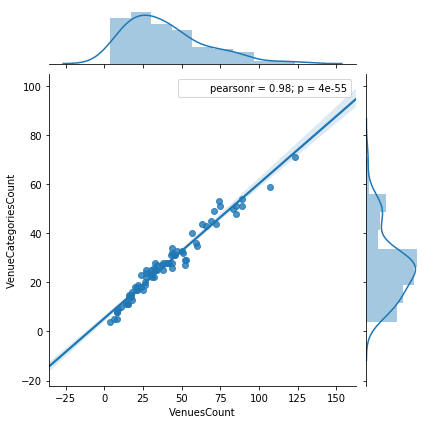

In [25]:
import seaborn as sns
ax = sns.jointplot(x="VenuesCount", y="VenueCategoriesCount", kind="reg", data=active_df)

Figure above demonstrates it. One can see it's higly correlated. The more places available, the more it's variety. It's dependend values. Let's take into consideration only total venues count for neighbourhood.

So we use neighbourhood venues count, neighbourhood area value as primary features. Additional useful feature is density = count/area. Then features are scaled and ready for clusterization. We should choose a set of features to be clustered. The most representative set is volume and density.

In [26]:
def scale(df, cols, scaler):
    """
    Scale passed columns for given dataframe
    
    Parameters:
    df     : dataframe
    cols   : columns list
    scaler : scaler
    """
    for col in cols:
        values = df[col].values.reshape(-1, 1)
        scaled_values = scaler.fit_transform(values)
        df[col+'Scaled'] = scaled_values

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
n_clusters = 4
cols = ['Density','Volume','VenuesCount','VenueCategoriesCount']
scale(active_df, cols, scaler)
cluster_df = active_df[['DensityScaled','VolumeScaled']]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cluster_df)
active_df['Cluster'] = kmeans.labels_

Let's examine feature clusterization on plot.

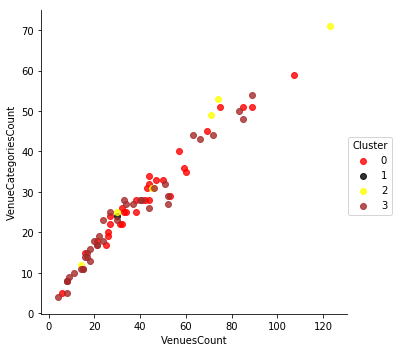

In [28]:
cluster_palette = {0:'red',1:'black',2:'yellow',3:'brown'}
ax = sns.lmplot(x='VenuesCount', y='VenueCategoriesCount', hue='Cluster', data=active_df, fit_reg=False, palette=cluster_palette)

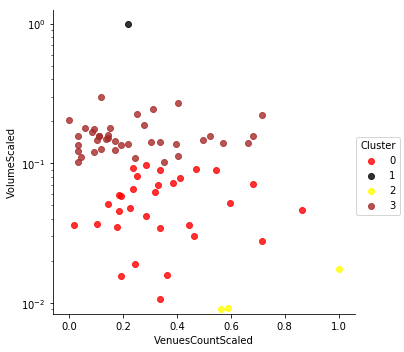

In [29]:
ax = sns.lmplot(x='VenuesCountScaled', y='VolumeScaled', hue='Cluster', data=active_df, fit_reg=False, palette=cluster_palette)
ax.set(yscale="log")

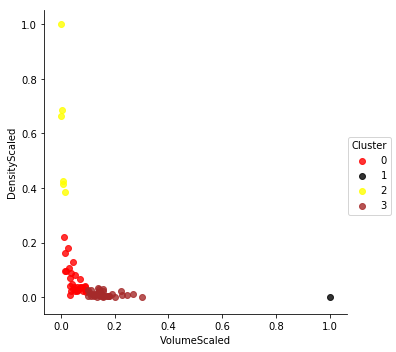

In [30]:

ax = sns.lmplot(x='VolumeScaled', y='DensityScaled', hue='Cluster', data=active_df, fit_reg=False, palette=cluster_palette)

## Results <a name="results"></a>

In [31]:
import matplotlib

def get_color(value, vmin=0 , vmax=1, map_name='hot'):
    """
    Returns color for current value for given color map
    
    Parameters:
    value    : current value
    vmin     : minimum  value
    vmax     : maximum value
    map_name : color map
    """
    cmap = matplotlib.cm.get_cmap(map_name)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    return matplotlib.colors.rgb2hex(cmap(norm(value)))

def draw_map(df, venues_df, cols):
    """
    Show folium map with neighbourhoods data: neighbourhoods, neighbourhood borders, venue points and additional dataframe data.
    Data shown as different feature groups and can be dynamically show/hide

    Parameters:
    df        : Dataframe with neighbourhoods data
    venues_df : Dataframe with venues data
    cols      : List of columns of df. Each column are shown as additional data.
    """
    avg_latitude = df.Latitude.mean()
    avg_longitude = df.Longitude.mean()
    folium_map = folium.Map(location=[avg_latitude, avg_longitude], zoom_start=11.5)
    neighbourhood_fg = folium.FeatureGroup(name='Neighbourhoods')
    borders_fg = folium.FeatureGroup(name='Neighbourhood borders')
    venues_fg = folium.FeatureGroup(name='Venue points')
    for col in cols:
        fg = folium.FeatureGroup(name=col) 
        vmin = df[col].min()
        vmax = df[col].max()
        for i,row in df.iterrows():
            region =  row['Region']
            latitude = row['Latitude']
            longitude = row['Longitude']
            value = row[col]
            label = '{}: {}'.format(col, value)
            if col == 'Cluster':
                color = cluster_palette[value]
            else:
                color = get_color(value, vmin, vmax)
            neighbourhood_fg.add_child(folium.CircleMarker([latitude, longitude], color='blue', radius=2, weight=0, fill=True, fill_opacity=1))
            borders_fg.add_child(folium.vector_layers.Polygon(locations=region, color='blue', weight=1, fill_opacity=0))
            fg.add_child(folium.vector_layers.Polygon(locations=region, fill_color=color, weight=0, fill_opacity=0.9, popup=(folium.Popup(label))))
        folium_map.add_child(fg)
    
    for lat, lng, in zip(venues_df['lat'], venues_df['lng']):
        venues_fg.add_child(folium.CircleMarker([lat, lng], color='black', radius=3, weight=0, fill=True, fill_opacity=0.9))
     
    folium_map.add_child(neighbourhood_fg)
    folium_map.add_child(borders_fg)
    folium_map.add_child(venues_fg)
    folium.LayerControl(collapsed=False).add_to(folium_map)
    return folium_map

#Show neighbourhoods on map. Show its venues, venue count, venue density for each neighbourhood. Show final neighbourhoods clusterization
draw_map(active_df, v_df.sample(frac=0.63, random_state=1), ['VenuesCount','Density','Cluster'])

## Discussion <a name="discussion"></a>

As a result we can view all available features rendered on map. One can explore the map and choose neighbourhood to rent apartment or to the business. One can choose by comparing different features. However the easiest way to choose neighbourhood within good clusters.
* The luxury cluster is yellow. It's right in the center of the city. His infrastructure is very good. The are a lot of different places. They all are close. Neighbourhoods are small.
* The good cluster is red. It is bigger. Neighbourhoods are larger. But the infrastructure is still good.
* The reasonable cluster is brown. It is the biggest cluster. Neighbourhoods are much larger. But the are not so much places available.
* The oulier is black. This is outskirts of the city. Neighbourhood is the largest. Nevertheless the ase a few places available. It's not enough for good infrastructure.

## Conclusion <a name="conclusion"></a>

Neighbourhood rating system is developed. In this article results are shown by example of the city of Toronto. This work implements key features such as:
* Approach applied to any city
* Neighbourhood's area regions automatically detected
* All features can be viewed over map and switched dynamically
* Additional features can be processed and viewed easily

This work is the beginning. The next step is taking into account additional features provided by Foursquare API.